# SageMaker Payment Classification 



## Background <a class="anchor" id="Background"></a>

This notebook demonstrates how you can train and deploy a machine learning model to classify payment transactions. Enriching financial transactions with the category of the transaction. This can be used as an intermediate step in fraud detection, personalization or anomaly detection. As well as a method to provide end users (e.g. customers at a bank) with an overview of their spending habits. Amazon SageMaker can be used to train and deploy a XGBoost model, as well as the required underlying infrastructure. For this notebook a generated dataset is used where a payment consists of mostly an amount, sender, receiver and timestamp.


## Notebook overview <a class="anchor" id="Notebook-overview"></a>

This notebook consists of seven parts. First, we import and configure the required libraries. After that we prepare the data used in this example and create the feature store. With the newly created features we create a XGBoost model. An endpoint is created to host this model. We evaluate the performance of the model and end by cleaning up the used resources.

## Dataset <a class="anchor" id="Dataset"></a>

For this notebook we use a synthetic dataset. This dataset has the following features 

* __transaction_category__: The category of the transaction, this is one of the next 19 options.

               'Uncategorized', 'Entertainment', 'Education',
                    'Shopping', 'Personal Care', 'Health and Fitness',
             'Food and Dining', 'Gifts and Donations', 'Investments',
         'Bills and Utilities', 'Auto and Transport', 'Travel',
            'Fees and Charges', 'Business Services', 'Personal Services',
                       'Taxes', 'Gambling', 'Home',
      'Pension and insurances'


* __receiver_id__: an identifier for the receiving party. The identifier consist of 16 numbers.
* __sender_id__: an identifier for the sending party. The identifier consist of 16 numbers.
* __amount__: the amount which is transferred.
* __timestamp__: the timestamp of the transaction in YYYY-MM-DD HH:MM:SS format.


## SageMaker


### 1. Setup <a class="anchor" id="Setup"></a>

Before we start we need to update the sagemaker library

In [1]:
# import sys

# !{sys.executable} -m pip install --upgrade pip       --quiet # upgrade pip to the latest vesion
# !{sys.executable} -m pip install --upgrade sagemaker --quiet # upgrade SageMaker to the latest vesion
# !{sys.executable} -m pip install --upgrade mlrun --quiet # upgrade mlrun to the latest vesion
# !{sys.executable} -m pip install --upgrade tarsafe --quiet # upgrade tarsafe to the latest vesion
# !{sys.executable} -m pip install --upgrade aiobotocore --quiet # upgrade aiobotocore to the latest vesion

Now that we have the latest version we can import the libraries that we'll use in this notebook

In [2]:
import boto3
import sagemaker
import time
import os

from time import sleep
from sklearn.metrics import classification_report
from sagemaker.feature_store.feature_group import FeatureGroup

import pandas as pd
import numpy as np

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[05/29/25 18:36:10] INFO     Found credentials from IAM Role:                                   ]8;id=764676;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=823274;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Let's set the session variables to ensure that SageMaker is configured correctly.

In [3]:
region = sagemaker.Session().boto_region_name
sm_client = boto3.client("sagemaker")
boto_session = boto3.Session(region_name=region)
sagemaker_session = sagemaker.session.Session(boto_session=boto_session, sagemaker_client=sm_client)
role = sagemaker.get_execution_role(use_default=True)
bucket_prefix = "payment-classification"
s3_bucket = sagemaker_session.default_bucket()

[05/29/25 18:36:11] INFO     Found credentials from IAM Role:                                   ]8;id=967391;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=941402;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=656224;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=591157;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[05/29/25 18:36:12] INFO     Found credentials from IAM Role:                                   ]8;id=89114;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=505505;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

We define the factorize key which is used to map the '__transaction_category__' to numeric values

In [4]:
factorize_key = {
    "Uncategorized": 0,
    "Entertainment": 1,
    "Education": 2,
    "Shopping": 3,
    "Personal Care": 4,
    "Health and Fitness": 5,
    "Food and Dining": 6,
    "Gifts and Donations": 7,
    "Investments": 8,
    "Bills and Utilities": 9,
    "Auto and Transport": 10,
    "Travel": 11,
    "Fees and Charges": 12,
    "Business Services": 13,
    "Personal Services": 14,
    "Taxes": 15,
    "Gambling": 16,
    "Home": 17,
    "Pension and insurances": 18,
}

factorize_key = {key: str(value) for key, value in factorize_key.items()}

### 2. Data preparation <a class="anchor" id="Data-preparation"></a>

We ingest the simulated data from the public SageMaker S3 training database:

In [5]:
s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{region}",
    "datasets/tabular/synthetic_financial/financial_transactions_mini.csv",
    "financial_transactions_mini.csv",
)

Let's start by loading the dataset from our csv file into a Pandas dataframe

In [6]:
data = pd.read_csv(
    "financial_transactions_mini.csv",
    parse_dates=["timestamp"],
    infer_datetime_format=True,
    dtype={"transaction_category": "string"},
)

/tmp/ipykernel_10800/3317469573.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(


The dataframe looks as follows:

| | transaction_category | receiver_id | sender_id | amount | timestamp |
|------:|:-----------------------|-----------------:|-----------------:|---------:|:--------------------|
| 39733 | Shopping | 4258863736072564 | 4630246970548037 | 91.58 | 2021-03-10 01:28:23 |
| 27254 | Shopping | 4356269497886716 | 4752313573239323 | 115.17 | 2021-01-22 23:28:24 |
| 30628 | Shopping | 4233636409552058 | 4635766441812956 | 90.98 | 2021-02-05 03:24:10 |
| 46614 | Shopping | 4054967431278644 | 4823810986511227 | 86.74 | 2021-04-02 14:42:45 |
| 37957 | Shopping | 4831814582525664 | 4254514582909482 | 123.27 | 2021-03-17 11:17:18 |
| 46878 | Shopping | 4425943481448900 | 4349267977109013 | 65.53 | 2021-03-17 15:47:49 |
| 81350 | Auto and Transport | 4146116413442105 | 4062723166078919 | 91.67 | 2021-03-29 13:23:44 |
| 10613 | Entertainment | 4788727923958282 | 4485838385631386 | 76.22 | 2021-02-11 17:45:53 |
| 46715 | Shopping | 4702782703461430 | 4944181591271506 | 86.67 | 2021-03-20 15:37:17 |
| 69110 | Investments | 4180233446952120 | 4702069426390603 | 530.39 | 2021-04-21 08:28:13 |

In [7]:
data.sample(10)

,transaction_category,receiver_id,sender_id,amount,timestamp
94190,Business Services,4748520238612978,4023544152594497,150.30,2021-03-31 14:34:51
34468,Shopping,4279387685690858,4743716313396991,148.31,2021-03-08 08:31:27
79409,Auto and Transport,4464705149164415,4640629465503583,105.39,2021-03-09 12:33:16
44437,Shopping,4599999821537828,4152417567675115,65.03,2021-04-22 00:40:22
96970,Gambling,4673971169666849,4384014188635576,655.60,2021-03-27 19:06:29
33941,Shopping,4794614858353949,4918573576345739,99.37,2021-02-01 17:44:32
36188,Shopping,4125784896465623,4562770859699324,83.91,2021-01-27 22:56:03
47763,Shopping,4147376191903178,4906986495935535,83.21,2021-01-17 21:42:13
98088,Home,4857090165935716,4231009661405005,191.67,2021-04-12 07:58:23
88272,Auto and Transport,4060068103287070,4073954194553733,42.50,2021-03-01 16:55:08


Next, we extract the year, month, day, hour, minute, second from the timestamp and remove the timestamp

In [8]:
data["year"] = data["timestamp"].dt.year
data["month"] = data["timestamp"].dt.month
data["day"] = data["timestamp"].dt.day
data["hour"] = data["timestamp"].dt.hour
data["minute"] = data["timestamp"].dt.minute
data["second"] = data["timestamp"].dt.second

del data["timestamp"]

We'll transform the transaction categories to numeric targets for the classification by factorization.

In [9]:
data["transaction_category"] = data["transaction_category"].replace(factorize_key)

### 3. Create feature store <a class="anchor" id="Create-feature-store"></a>

To enrich dataset we will use the [Feature Store](https://aws.amazon.com/sagemaker/feature-store/). 

Before creating the feature store itself we need to set a name for the feature group and identifier used

In [10]:
feature_group_name = "feature-group-payment-classification"
record_identifier_feature_name = "identifier"

With the name we defined we create the feature group, runtime and session

In [11]:
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker_session)

featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)

feature_store_session = sagemaker.Session(
    boto_session=boto_session,
    sagemaker_client=sm_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

Once we have defined our feature store we need to put some data in it. We create a Pandas dataframe with the columns mean_amount, count, identifier and event time to store in the feature store

In [12]:
columns = ["mean_amount", "count", "identifier", "EventTime"]
feature_store_data = pd.DataFrame(columns=columns, dtype=object)

feature_store_data["identifier"] = range(19)
feature_store_data["mean_amount"] = 0.0
feature_store_data["count"] = 1
feature_store_data["EventTime"] = time.time()

Using the created dataframe we set the feature definitions

In [13]:
feature_group.load_feature_definitions(data_frame=feature_store_data)

[FeatureDefinition(feature_name='mean_amount', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='count', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='identifier', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='EventTime', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None)]

With these definitions ready we can create the feature group itself

In [17]:
feature_group.create(
    s3_uri=f"s3://{s3_bucket}/{bucket_prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name="EventTime",
    role_arn=role,
    enable_online_store=True,
)

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-2:934638699319:feature-group/feature-group-payment-classification',
 'ResponseMetadata': {'RequestId': '22fe42f1-f670-464d-8369-02223939c29e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '22fe42f1-f670-464d-8369-02223939c29e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Thu, 29 May 2025 18:37:05 GMT'},
  'RetryAttempts': 0}}

It takes a couple of minutes for the feature group to be created, we need to wait for this to be done before trying to ingest data in the feature store

In [18]:
status = feature_group.describe().get("FeatureGroupStatus")
while status == "Creating":
    print("Waiting for Feature Group to be Created")
    time.sleep(5)
    status = feature_group.describe().get("FeatureGroupStatus")
print(f"FeatureGroup {feature_group.name} successfully created.")

Waiting for Feature Group to be Created
Waiting for Feature Group to be Created
Waiting for Feature Group to be Created
FeatureGroup feature-group-payment-classification successfully created.


Once the feature group is created we can ingest data into it

In [19]:
feature_group.ingest(data_frame=feature_store_data, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='feature-group-payment-classification', feature_definitions={'mean_amount': {'FeatureName': 'mean_amount', 'FeatureType': 'Fractional'}, 'count': {'FeatureName': 'count', 'FeatureType': 'Integral'}, 'identifier': {'FeatureName': 'identifier', 'FeatureType': 'Integral'}, 'EventTime': {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}}, sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7facc6f64190>, sagemaker_session=<sagemaker.session.Session object at 0x7fad0c2c5f90>, max_workers=3, max_processes=1, profile_name=None, _async_result=<multiprocess.pool.MapResult object at 0x7facc28aa170>, _processing_pool=<pool ProcessPool(ncpus=1)>, _failed_indices=[])

To retrieve data from our feature store we define a function that gets the current values from the feature store

In [20]:
def get_feature_store_values():
    response = featurestore_runtime.batch_get_record(
        Identifiers=[
            {
                "FeatureGroupName": feature_group_name,
                "RecordIdentifiersValueAsString": [str(i) for i in range(19)],
            }
        ]
    )

    columns = ["mean_amount", "count", "identifier", "EventTime"]

    feature_store_resp = pd.DataFrame(
        data=[
            [resp["Record"][i]["ValueAsString"] for i in range(len(columns))]
            for resp in response["Records"]
        ],
        columns=columns,
    )
    feature_store_resp["identifier"] = feature_store_resp["identifier"].astype(int)
    feature_store_resp["count"] = feature_store_resp["count"].astype(int)
    feature_store_resp["mean_amount"] = feature_store_resp["mean_amount"].astype(float)
    feature_store_resp["EventTime"] = feature_store_resp["EventTime"].astype(float)
    feature_store_resp = feature_store_resp.sort_values(by="identifier")

    return feature_store_resp


feature_store_resp = get_feature_store_values()

We update the values in the feature store with the real values of our data

In [21]:
feature_store_data = pd.DataFrame()
feature_store_data["mean_amount"] = data.groupby(["transaction_category"]).mean()["amount"]
feature_store_data["count"] = data.groupby(["transaction_category"]).count()["amount"]
feature_store_data["identifier"] = feature_store_data.index
feature_store_data["EventTime"] = time.time()

feature_store_data["mean_amount"] = (
    pd.concat([feature_store_resp, feature_store_data])
    .groupby("identifier")
    .apply(lambda x: np.average(x["mean_amount"], weights=x["count"]))
)
feature_store_data["count"] = (
    pd.concat([feature_store_resp, feature_store_data]).groupby("identifier").sum()["count"]
)

feature_group.ingest(data_frame=feature_store_data, max_workers=3, wait=True)

IngestionManagerPandas(feature_group_name='feature-group-payment-classification', feature_definitions={'mean_amount': {'FeatureName': 'mean_amount', 'FeatureType': 'Fractional'}, 'count': {'FeatureName': 'count', 'FeatureType': 'Integral'}, 'identifier': {'FeatureName': 'identifier', 'FeatureType': 'Integral'}, 'EventTime': {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}}, sagemaker_fs_runtime_client_config=<botocore.config.Config object at 0x7facc6f64190>, sagemaker_session=<sagemaker.session.Session object at 0x7fad0c2c5f90>, max_workers=3, max_processes=1, profile_name=None, _async_result=<multiprocess.pool.MapResult object at 0x7facc28abf10>, _processing_pool=<pool ProcessPool(ncpus=1)>, _failed_indices=[])

And display them after getting them from the feature store

In [22]:
feature_store_data = get_feature_store_values()
feature_store_data

,mean_amount,count,identifier,EventTime
2,495.837355,465,0,1.748544e+09
15,51.209382,14512,1,1.748544e+09
11,851.153495,744,2,1.748544e+09
14,100.917503,33953,3,1.748544e+09
5,31.504036,1209,4,1.748544e+09
8,119.596405,4837,5,1.748544e+09
4,93.249393,9674,6,1.748544e+09
16,51.072447,2791,7,1.748544e+09
17,6024.547484,930,8,1.748544e+09
10,114.779558,3349,9,1.748544e+09


We use the feature store to calculate the distance between the average of every category and the current amount

In [23]:
additional_features = pd.pivot_table(
    feature_store_data, values=["mean_amount"], index=["identifier"]
).T.add_suffix("_dist")
additional_features_columns = list(additional_features.columns)
data = pd.concat([data, pd.DataFrame(columns=additional_features_columns, dtype=object)])
data[additional_features_columns] = additional_features.values[0]
for col in additional_features_columns:
    data[col] = abs(data[col] - data["amount"])

data.sample(5)

,transaction_category,receiver_id,sender_id,amount,year,month,day,hour,minute,second,...,9_dist,10_dist,11_dist,12_dist,13_dist,14_dist,15_dist,16_dist,17_dist,18_dist
58779,6,4.411648e+15,4.121018e+15,292.91,2021.0,1.0,11.0,10.0,23.0,11.0,...,178.130442,191.93289,58.897588,265.959441,88.170803,203.856086,2620.763247,82.318871,488.482199,87.452849
67243,7,4.773225e+15,4.444914e+15,66.80,2021.0,2.0,7.0,0.0,10.0,57.0,...,47.979558,34.17711,285.007588,39.849441,137.939197,429.966086,2846.873247,308.428871,714.592199,138.657151
42123,3,4.600000e+15,4.199025e+15,46.25,2021.0,1.0,21.0,16.0,2.0,26.0,...,68.529558,54.72711,305.557588,19.299441,158.489197,450.516086,2867.423247,328.978871,735.142199,159.207151
18493,3,4.577051e+15,4.643030e+15,72.23,2021.0,2.0,3.0,6.0,26.0,42.0,...,42.549558,28.74711,279.577588,45.279441,132.509197,424.536086,2841.443247,302.998871,709.162199,133.227151
97469,17,4.658295e+15,4.929308e+15,883.29,2021.0,2.0,10.0,16.0,47.0,37.0,...,768.510442,782.31289,531.482412,856.339441,678.550803,386.523914,2030.383247,508.061129,101.897801,677.832849


### 4. Create model <a class="anchor" id="Create-model"></a>
In this notebook we will be using the [Extreme Gradient Boosting](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) (XGBoost) implementation of the gradient boosted trees algorithm. This model is selected due to it relatively fast training time and explainable properties. The model can be substituted at will a different [SageMaker estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) or a [model of your choosing](https://aws.amazon.com/blogs/machine-learning/bring-your-own-model-with-amazon-sagemaker-script-mode/).



Now that we have the dataset we can start preparing the model. First, we create a training, validation and testing split.

In [24]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(
    data.sample(frac=1, random_state=42), [int(0.7 * len(data)), int(0.9 * len(data))]
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


We save these sets to a file.

In [25]:
train_data.to_csv("train.csv", index=False, header=False)
validation_data.to_csv("validation.csv", index=False, header=False)
test_data.to_csv("test.csv", index=False, header=True)

And upload these files to our s3 bucket

In [26]:
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(bucket_prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(bucket_prefix, "validation/validation.csv")
).upload_file("validation.csv")
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(bucket_prefix, "test/test.csv")
).upload_file("test.csv")

[05/29/25 18:37:30] INFO     Found credentials from IAM Role:                                   ]8;id=42032;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=894407;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[05/29/25 18:37:31] INFO     Found credentials from IAM Role:                                   ]8;id=975372;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=750370;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=392529;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=952905;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Get the XGBoost sagemaker image

In [27]:
container = sagemaker.image_uris.retrieve(region=region, framework="xgboost", version="1.2-2")

[05/29/25 18:37:32] INFO     Ignoring unnecessary instance type: None.                            ]8;id=162995;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=304519;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Transform our data to a sagemaker input for training

In [28]:
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/train".format(s3_bucket, bucket_prefix), content_type="csv"
)
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/validation/".format(s3_bucket, bucket_prefix), content_type="csv"
)

We define the XGBoost model

In [29]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(s3_bucket, bucket_prefix),
    sagemaker_session=sagemaker_session,
)

Set the parameters

In [30]:
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="multi:softprob",
    num_class=19,
    verbosity=0,
    num_round=100,
)

And train the model

In [31]:
xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=856048;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=492274;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=579138;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=549242;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1053\1053]8;;\
                             sagemaker-xgboost-2025-05-29-18-37-32-227                                             

2025-05-29 18:37:32 Starting - Starting the training job...
2025-05-29 18:37:56 Starting - Preparing the instances for training...
2025-05-29 18:38:18 Downloading - Downloading input data...
2025-05-29 18:38:48 Downloading - Downloading the training image......
2025-05-29 18:39:43 Training - Training image download completed. Training in progress...[2025-05-29 18:39:55.955 ip-10-0-126-60.us-east-2.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-05-29:18:39:55:INFO] Imported framework sagemaker_xgboost_container.training
[2025-05-29:18:39:55:INFO] Failed to parse hyperparameter objective value multi:softprob to Json.
Returning the value itself
[2025-05-29:18:39:55:INFO] No GPUs detected (normal if no gpus installed)
[2025-05-29:18:39:56:INFO] Running XGBoost Sagemaker in algorithm mode
[2025-05-29:18:39:56:INFO] Determined delimiter of CSV input is ','
[2025-05-29:18:39:56:INFO] Determined delimiter of CSV input is ','
[2025-05-29:18:39:56:INFO] Determined

## MLRun

### 5. Using the endpoint <a class="anchor" id="Using-the-endpoint"></a>

Deploy the model to an endpoint

In [32]:
import mlrun

Install packages

In [33]:
%pip install graphviz xgboost

Note: you may need to restart the kernel to use updated packages.


In [35]:
project = mlrun.get_or_create_project(
    name="sagemaker", 
    user_project=True,
    parameters={
        # "source" : "git://github.com/mlrun/demo-sagemaker#main",
    }
)

> 2025-05-29 18:49:10,422 [info] Loading project from path: {"path":"./","project_name":"sagemaker","user_project":true}
> 2025-05-29 18:49:10,426 [warning] Project name mismatch, sagemaker-ec2-user != sagemaker-felipe, project is loaded from sagemaker-ec2-user project yaml. To prevent/allow this, you can take one of the following actions:
1. Set the `allow_cross_project=True` when loading the project.
2. Delete the existing project yaml, or ensure its name is equal to sagemaker-felipe.
3. Use different project context dir.


Project name='sagemaker-felipe' is different than specified on the context's project yaml. This behavior is deprecated and will not be supported from version 1.9.0.


Building default image for the demo:
> 2025-05-29 18:49:25,480 [info] Started building image: .mlrun-project-image-sagemaker-felipe


The `overwrite_build_params` parameter default will change from 'False' to 'True' in 1.9.0.


Enumerating objects: 329, done.
Counting objects: 100% (92/92), done.
Compressing objects: 100% (56/56), done.
Total 329 (delta 43), reused 43 (delta 36), pack-reused 237 (from 2)
INFO[0000] Retrieving image manifest mlrun/mlrun:1.8.0-rc56 
INFO[0000] Retrieving image mlrun/mlrun:1.8.0-rc56 from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:1.8.0-rc56 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Building stage 'mlrun/mlrun:1.8.0-rc56' [idx: '0', base-idx: '-1'] 
INFO[0000] Unpacking rootfs as cmd ADD . /home/mlrun_code/ requires it. 
INFO[0033] ARG AWS_ACCESS_KEY_ID=$AWS_ACCESS_KEY_ID     
INFO[0033] ARG AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION   
INFO[0033] ARG AWS_SECRET_ACCESS_KEY=$AWS_SECRET_ACCESS_KEY 
INFO[0033] ARG SAGEMAKER_ROLE=$SAGEMAKER_ROLE           
INFO[0033] Using files from context: [/kaniko/buildcontext] 


In [36]:
serving_function = project.get_function("serving")

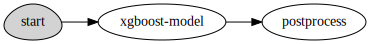

In [37]:
# Set the topology and get the graph object:
graph = serving_function.set_topology("flow", engine="async")

# Add the steps:
graph.to("XGBModelServer",
         name="xgboost-model",
         model_path=xgb.model_data) \
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph:
serving_function.plot(rankdir='LR')

In [38]:
server = serving_function.to_mock_server()

Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


> 2025-05-29 18:51:51,633 [info] model xgboost-model was loaded
{'id': '5885567e43424ed9a9fdc3b0b4f932eb', 'model_name': 'xgboost-model', 'outputs': [[0.0001946827833307907, 0.4333091080188751, 0.00045870488975197077, 0.429901123046875, 0.0018640152411535382, 0.006989223882555962, 0.022358348593115807, 0.03379629924893379, 0.00020731751283165067, 0.005750253330916166, 0.05224216356873512, 0.00037217975477688015, 0.0003981783229392022, 0.0006151106208562851, 0.000131972148665227, 0.0001632201747270301, 0.00013299261627253145, 0.0048257941380143166, 0.006289314478635788], [0.0011100886622443795, 0.5875383019447327, 0.0003125712973996997, 0.16625414788722992, 0.005176760256290436, 0.060638777911663055, 0.09993327409029007, 0.009868890047073364, 0.0002663227205630392, 0.018568776547908783, 0.046347636729478836, 0.0006216198671609163, 0.0006515536224469543, 0.0013189689489081502, 0.00015808921307325363, 0.00024295855837408453, 0.00015932851238176227, 0.00035576705704443157, 0.00047617882955

In [39]:
samples = test_data.drop('transaction_category',axis=1)[:500].values.tolist()

In [40]:
response = server.test(body={"inputs": samples[:5]})
print(response['predictions'])

[1, 1, 11, 3, 1]


In [ ]:
project.deploy_function("serving")

> 2025-05-29 18:51:51,659 [info] Starting remote function deploy
2025-05-29 18:51:52  (info) Deploying function
2025-05-29 18:51:52  (info) Building
2025-05-29 18:51:52  (info) Staging files and preparing base images
2025-05-29 18:51:52  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-05-29 18:51:52  (info) Building processor image


In [ ]:
response = serving_function.invoke(path='/predict', body={"inputs": samples})

In [ ]:
print(response['predictions'][:10])

### 6. Evaluate performance <a class="anchor" id="Evaluate-performance"></a>

Run the model on our test data

In [ ]:
s3_data = "s3://{}/{}/test/test.csv".format(s3_bucket, bucket_prefix)

In [ ]:
evaluate_function = project.get_function("evaluate")

In [ ]:
xgb.model_data

In [ ]:
s3_data

In [ ]:
evaluate_run = evaluate_function.run(
    handler="evaluate",
    params={
        "model_path": xgb.model_data,
        "model_name": "xgboost-model",
        "test_set": s3_data,
        "label_column": "transaction_category",
        "factorize_key": factorize_key,
    },
    returns=["classification_report: dataset"])

In [ ]:
evaluate_run.artifact("classification_report").as_df()

You should see results similar to this:

```
                        precision    recall  f1-score   support

         Uncategorized       1.00      0.92      0.96        51
         Entertainment       0.81      0.89      0.85      1486
             Education       1.00      0.94      0.97        80
              Shopping       0.86      0.94      0.90      3441
         Personal Care       1.00      0.98      0.99       132
    Health and Fitness       0.99      0.89      0.94       443
       Food and Dining       0.99      0.82      0.90       918
   Gifts and Donations       1.00      0.95      0.97       275
           Investments       0.99      0.97      0.98        88
   Bills and Utilities       1.00      0.99      1.00       332
    Auto and Transport       0.94      0.84      0.88      1967
                Travel       0.96      0.84      0.90       120
      Fees and Charges       1.00      0.94      0.97       106
     Business Services       1.00      0.99      1.00       146
     Personal Services       1.00      0.96      0.98        75
                 Taxes       0.98      0.94      0.96        47
              Gambling       1.00      1.00      1.00        15
                  Home       0.98      0.89      0.93       168
Pension and insurances       0.99      1.00      1.00       110

              accuracy                           0.90     10000
             macro avg       0.97      0.93      0.95     10000
          weighted avg       0.91      0.90      0.90     10000
```

### 7. Clean up <a class="anchor" id="Clean-up"></a>

Remove the feature group and endpoint to clean up

In [ ]:
feature_group.delete()
# xgb_predictor.delete_endpoint(delete_endpoint_config=True)